In [1]:
!mkdir /content/saved_models

# Imports and Utility functions

## <font color='orange'>Imports</font>

In [2]:
#!pip3 install tensorboard --upgrade

In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:16000"

In [4]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#import skvideo.io as vidio
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py
#from tabulate import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as tF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision import datasets, transforms, models
#from torchviz import make_dot
#from torchsummary import summary

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

In [5]:
# from torchvision.models.utils import load_state_dict_from_url
from torch.hub import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from collections import OrderedDict

In [6]:
from sklearn.manifold import TSNE

In [7]:
def set_seed(seed = 16):
    np.random.seed(16)
    torch.manual_seed(16)

#### CIFAR 10

In [8]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2024-02-29 22:41:56--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  85.4MB/s    in 1.9s    

2024-02-29 22:41:58 (85.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [9]:
!tar -xf /content/cifar-10-python.tar.gz

In [10]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [11]:
train_files = ['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5']
images = np.array([],dtype=np.uint8).reshape((0,3072))
labels = np.array([])
for tf in train_files:
    data_dict = unpickle('/content/cifar-10-batches-py/'+tf)
    data = data_dict[b'data']

    images = np.append(images,data,axis=0)
    labels = np.append(labels,data_dict[b'labels'])
print(images.shape, labels.shape)

(50000, 3072) (50000,)


In [12]:
testimages = np.array([],dtype=np.uint8).reshape((0,3072))
testlabels = np.array([])

data_dict = unpickle('/content/cifar-10-batches-py/test_batch')
# print(data_dict)
data = data_dict[b'data']
testimages = np.append(testimages,data,axis=0)
testlabels = np.append(testlabels,data_dict[b'labels'])
print(testimages.shape, testlabels.shape)

(10000, 3072) (10000,)


In [13]:
images = images.reshape((-1,3,32,32))
testimages = testimages.reshape((-1,3,32,32))

print(images.shape, testimages.shape)

(50000, 3, 32, 32) (10000, 3, 32, 32)


In [14]:
images = images.astype(float)
testimages = testimages.astype(float)

In [15]:
trimages = np.moveaxis(images,1,3)
tsimages = np.moveaxis(testimages,1,3)
print(trimages.shape, tsimages.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [16]:
labels = labels.astype(int)
testlabels = testlabels.astype(int)

In [17]:
lab_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

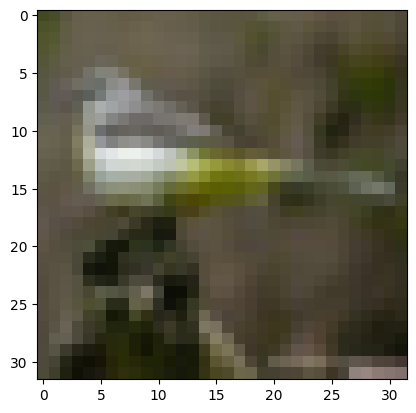

bird


In [18]:
plt.imshow(trimages[57]/255.0)
plt.show()
print(lab_dict[labels[57]])



```
# This is formatted as code
```

### <font color='blue'>Performance Metrics</font>

In [19]:
#util_wk2
def TP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def TN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def FN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))

def FP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

def get_accuracy(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)

    return (tp+tn)/(tp+fp+tn+fn)

def get_prevalence(y):
    return np.sum(y)/y.shape[0]

def sensitivity(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fn = FN(y,pred,th)

    return tp/(tp+fn)

def specificity(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fp = FP(y,pred,th)

    return tn/(tn+fp)

def get_ppv(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)

    return tp/(tp+fp)

def get_npv(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)

    return tn/(tn+fn)


def get_performance_metrics(y, pred, class_labels, tp=TP,
                            tn=TN, fp=FP,
                            fn=FN,
                            acc=get_accuracy, prevalence=get_prevalence,
                            spec=specificity,sens=sensitivity, ppv=get_ppv,
                            npv=get_npv, auc=roc_auc_score, f1=f1_score,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["Injury", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [class_labels[i],
                     round(tp(y[:, i], pred[:, i]),3),
                     round(tn(y[:, i], pred[:, i]),3),
                     round(fp(y[:, i], pred[:, i]),3),
                     round(fn(y[:, i], pred[:, i]),3),
                     round(acc(y[:, i], pred[:, i], thresholds[i]),3),
                     round(prevalence(y[:, i]),3),
                     round(sens(y[:, i], pred[:, i], thresholds[i]),3),
                     round(spec(y[:, i], pred[:, i], thresholds[i]),3),
                     round(ppv(y[:, i], pred[:, i], thresholds[i]),3),
                     round(npv(y[:, i], pred[:, i], thresholds[i]),3),
                     round(auc(y[:, i], pred[:, i]),3),
                     round(f1(y[:, i], pred[:, i] > thresholds[i]),3),
                     round(thresholds[i], 3)]

    df = df.set_index("Injury")
    return df

def bootstrap_metric(y, pred, classes, metric='auc',bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))
    if metric=='AUC':
        metric_func = roc_auc_score
    if metric=='Sensitivity':
        metric_func = sensitivity
    if metric=='Specificity':
        metric_func = specificity
    if metric=='Accuracy':
        metric_func = get_accuracy
    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = metric_func(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

def get_confidence_intervals(y,pred,class_labels):

    metric_dfs = {}
    for metric in ['AUC','Sensitivity','Specificity','Accuracy']:
        statistics = bootstrap_metric(y,pred,class_labels,metric)
        df = pd.DataFrame(columns=["Mean "+metric+" (CI 5%-95%)"])
        for i in range(len(class_labels)):
            mean = statistics.mean(axis=1)[i]
            max_ = np.quantile(statistics, .95, axis=1)[i]
            min_ = np.quantile(statistics, .05, axis=1)[i]
            df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
        metric_dfs[metric] = df
    return metric_dfs


### <font color='blue'>Plotting Metrics</font>

#### <font color='red'>Accuracy</font>

In [20]:
def plot_accuracy(tr_acc,val_acc):
    # Plot training & validation accuracy values
    plt.plot(tr_acc)
    plt.plot(val_acc)
    plt.title('Model accuracy',fontsize=10)
    plt.ylabel('Accuracy',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('accuracy_plot.png')
    plt.show()

#### <font color='red'>Loss</font>

In [21]:
def plot_loss(tr_loss,val_loss):
    # Plot training & validation loss values
    plt.plot(tr_loss)
    plt.plot(val_loss)
    plt.title('Model loss',fontsize=10)
    plt.ylabel('Loss',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('loss_plot.png')
    plt.show()

#### <font color='red'>ROC</font>

In [22]:
def get_roc_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " AUC: %.3f " % auc_roc
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('ROC_Curve.png')
        plt.show()

#### <font color='red'>Precision and Recall</font>

In [23]:
def get_PR_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
        average_precision = average_precision_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " Avg.: %.3f " % average_precision
        plt.figure(1, figsize=(7, 7))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('Precision_and_Recall_curve.png')
        plt.show()

#### <font color='red'>Confusion Matrix</font>  

In [24]:
def plot_confusion_matrix(y_true,y_pred,class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(60,60))
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    fig.savefig('Confusion_Matrix.png')
    plt.show()

#### <font color='red'>Performance Metrics with Errorbars</font>

In [25]:
#04_03_Errorbar.ipynb
def plot_perf_metrics_errbars(y,pred,class_labels):
    metric_dfs = get_confidence_intervals(y,pred,class_labels)
    metrics = metric_dfs.keys()
    fig,axs = plt.subplots(len(metrics),1,sharey=True)
    for i in range(len(metrics)):
        ci = metric_dfs[metric][['Mean '+metrics[i]+' (CI 5%-95%)']].values
        ci_mean,ci_ints = np.array([c[0].split(' ') for c in ci]).T
        ci_mean = ci_mean.astype(float)
        ci_min,ci_max = np.array([ci_ints.strip('()').split('-')]).astype(float)
        ci_err = (ci_max-ci_min)/2

        axs[i].errorbar(class_labels,ci_mean,yerr=ci_err,capsize=5,fmt='dk')
        axs[i].set_ylabel(metrics[i])
    fig.savefig('Performance_Metrics_95percentCI.png')
    plt.show()

## Data Generator for Contrastive Learning


### Augmentations

#### Cutout

In [26]:
class Cutout(nn.Module):
    def __init__(self, seed = 0):
        self.seed = seed

    def get_start_index(self,L):
        return np.random.randint(L)

    def __call__(self,frame):
        channels, h, w = frame.shape
        #print(frames.shape)
        size = h//4
        n_squares = np.random.randint(1,3,1)[0]
        new_image = frame
        for _ in range(n_squares):
            y = np.clip(self.get_start_index(h), size // 2, h - size//2)
            x = np.clip(self.get_start_index(w), size // 2, w - size//2)

            y1 = np.clip(y - size // 2, 0, h)
            y2 = np.clip(y + size // 2, 0, h)
            x1 = np.clip(x - size // 2, 0, w)
            x2 = np.clip(x + size // 2, 0, w)
            new_image[:, y1:y2,x1:x2] = 0
        return new_image

#### Gaussian Noise

In [27]:
class AddGaussianNoise(nn.Module):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

### Datagen

###### CIFAR 10

In [28]:
MEAN = np.mean(images[:40000]/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(images[:40000]/255.0,axis=(0,2,3),keepdims=True)

print(MEAN, STD)

[[[[0.49145363]]

  [[0.48206213]]

  [[0.44622512]]]] [[[[0.24716829]]

  [[0.24370658]]

  [[0.26169213]]]]


In [29]:
class C10DataGen(Dataset):
    def __init__(self,phase,imgarr,s = 0.5):
        self.phase = phase
        self.imgarr = imgarr
        self.s = s
        self.transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                              transforms.RandomResizedCrop(32,(0.8,1.0)),
                                              transforms.Compose([transforms.RandomApply([transforms.ColorJitter(0.8*self.s,
                                                                                                                 0.8*self.s,
                                                                                                                 0.8*self.s,
                                                                                                                 0.2*self.s)], p = 0.8),
                                                                  transforms.RandomGrayscale(p=0.2)
                                                                 ])])

    def __len__(self):
        return self.imgarr.shape[0]

    def __getitem__(self,idx):

        x = self.imgarr[idx]
        #print(x.shape)
        x = x.astype(np.float32)/255.0

        x1 = self.augment(torch.from_numpy(x))
        x2 = self.augment(torch.from_numpy(x))

        x1 = self.preprocess(x1)
        x2 = self.preprocess(x2)

        return x1, x2

    #shuffles the dataset at the end of each epoch
    def on_epoch_end(self):
        self.imgarr = self.imgarr[random.sample(population = list(range(self.__len__())),k = self.__len__())]

    def preprocess(self,frame):
        frame = (frame-MEAN)/STD
        return frame

    #applies randomly selected augmentations to each clip (same for each frame in the clip)
    def augment(self, frame, transformations = None):

        if self.phase == 'train':
            frame = self.transforms(frame)
        else:
            return frame

        return frame

#### DataGen Test

In [30]:
dg = C10DataGen('train',images) #train_df)
dl = DataLoader(dg,batch_size = 8)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


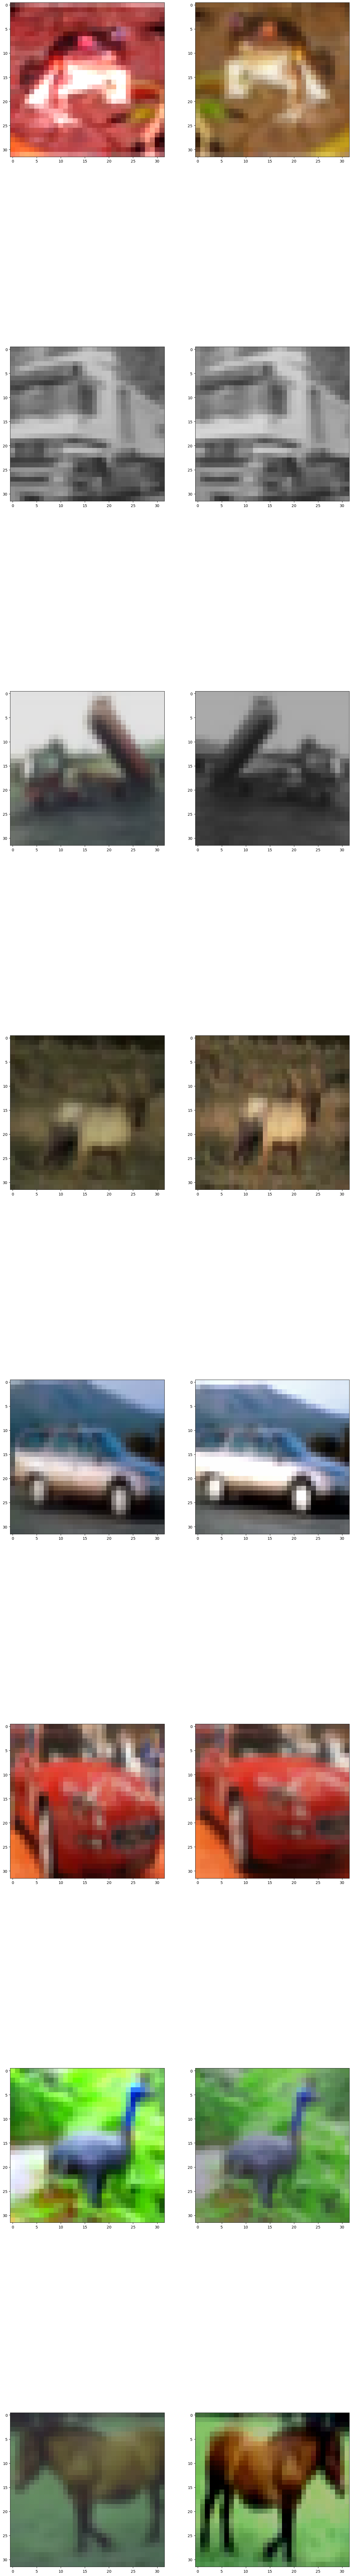

In [31]:
#MEAN = np.array([0.485, 0.456, 0.406]).reshape((1,1,3))
#STD = np.array([0.229, 0.224, 0.25]).reshape((1,1,3))
fig,axs = plt.subplots(8,2,figsize=(16,128))
row = 0
col = 0
for step,(x1,x2) in enumerate(dl):

    for i in range(8):
        #print(x1[i]*STD + MEAN)
        #print(x2[i]*STD + MEAN)
        axs[i,0].imshow((x1[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
        axs[i,1].imshow((x2[i]*STD + MEAN).squeeze().permute(1,2,0).numpy())
    break

## Model

### Final Code

In [32]:
set_seed(16)

In [33]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super(LinearLayer, self).__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn

        self.linear = nn.Linear(self.in_features,
                                self.out_features,
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super(ProjectionHead,self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features,self.out_features,False, True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features,self.hidden_features,True, True),
                nn.ReLU(),
                LinearLayer(self.hidden_features,self.out_features,False,True))

    def forward(self,x):
        x = self.layers(x)
        return x

class PreModel(nn.Module):
    def __init__(self,base_model,base_out_layer):
        super().__init__()
        self.base_model = base_model
        self.base_out_layer = base_out_layer

        #PRETRAINED MODEL
        self.pretrained = models.resnet50(pretrained=True)

        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()

        self.pretrained.fc = Identity()

        for p in self.pretrained.parameters():
            p.requires_grad = True

        self.projector = ProjectionHead(2048, 2048, 128)


    def forward(self,x):
        out = self.pretrained(x)

        xp = self.projector(torch.squeeze(out))

        return xp

In [34]:
model = PreModel('resnet50','avgpool')
model = model.to('cuda:0')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 52.4MB/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
print(model)

In [ ]:
x = np.random.random((8,3,224,224))

In [ ]:
out = model(torch.tensor(x, device = 'cuda:0', dtype = torch.float32))

In [ ]:
out[0].shape, out[1].shape


### Training

In [ ]:
def load_optimizer(arg_optimizer, model, batch_size):

    scheduler = None
    if arg_optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # TODO: LARS
    elif arg_optimizer == "LARS":
        # optimized using LARS with linear learning rate scaling
        # (i.e. LearningRate = 0.3 × BatchSize/256) and weight decay of 10−6.
        learning_rate = 0.3 * batch_size / 256
        optimizer = LARS(
            [params for params in model.parameters() if params.requires_grad],
            lr=0.1,
            weight_decay=1e-6,
            exclude_from_weight_decay=["batch_normalization", "bias"],
        )

        # "decay the learning rate with the cosine decay schedule without restarts"
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, epochs, eta_min=0, last_epoch=-1
        )
    else:
        raise NotImplementedError

    return optimizer, scheduler

def save_model(model, optimizer, scheduler, current_epoch, name):
    out = os.path.join('/content/saved_models/',name.format(current_epoch))

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict':scheduler.state_dict()}, out)

In [ ]:
!mkdir /content/saved_models

#### Loss

In [ ]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(SimCLR_Loss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

        self.tot_neg = 0

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)

        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0

        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        N = 2 * self.batch_size #* self.world_size

        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        #print(sim.shape)

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)


        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)


        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

#### Optimizer

In [ ]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

In [ ]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = True)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = True)

In [ ]:
criterion = (SimCLR_Loss(batch_size = 64, temperature = 0.5))

In [ ]:
trimages = images[:40000]
valimages = images[40000:]
trlabels = labels[:40000]
vallabels = labels[40000:]

In [ ]:
dg = C10DataGen('train',trimages)#train_df)
dl = DataLoader(dg,batch_size = 64,drop_last=True)

In [ ]:
vdg = C10DataGen('valid',valimages)#_df)
vdl = DataLoader(vdg,batch_size = 64,drop_last=True)

In [ ]:
plt.hist(vallabels)

#### Real Training

In [ ]:

nr = 0
global_step = 0
current_epoch = 0
epochs = 100

In [ ]:
def plot_features(model, num_classes, num_feats, batch_size, val_df = None):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for x1,x2 in vdl:
            x1 = x1.squeeze().to(device = 'cuda:0', dtype = torch.float)#.view((-1,3,224,224))
            #y = y.to(device = 'cuda:0')#.view((-1,1))
            out = model(x1)
            out = out.cpu().data.numpy()#.reshape((1,-1))
            feats = np.append(feats,out,axis = 0)

    tsne = TSNE(n_components = 2, perplexity = 50)
    x_feats = tsne.fit_transform(feats)
    #plt.scatter(x_feats[:,1],x_feats[:,0])
    num_samples = int(batch_size*(valimages.shape[0]//batch_size))#(len(val_df)

    for i in range(num_classes):
        #plt.scatter(x_feats[val_df['class'].iloc[:num_samples].values==i,1],x_feats[val_df['class'].iloc[:num_samples].values==i,0])
        plt.scatter(x_feats[vallabels[:num_samples]==i,1],x_feats[vallabels[:num_samples]==i,0])

    plt.legend([str(i) for i in range(num_classes)])
    plt.show()

In [ ]:
plot_features(model.pretrained, 10, 2048, 64)

In [ ]:
def train(train_loader, model, criterion, optimizer):
    loss_epoch = 0

    for step, (x_i, x_j) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = x_i.squeeze().to('cuda:0').float()
        x_j = x_j.squeeze().to('cuda:0').float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()

        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [ ]:
def valid(valid_loader, model, criterion):
    loss_epoch = 0
    for step, (x_i, x_j) in enumerate(valid_loader):

        x_i = x_i.squeeze().to('cuda:0').float()
        x_j = x_j.squeeze().to('cuda:0').float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)

        if nr == 0 and step % 50 == 0:
            print(f"Step [{step}/{len(valid_loader)}]\t Loss: {round(loss.item(),5)}")

        loss_epoch += loss.item()
    return loss_epoch

In [ ]:
tr_loss = []
val_loss = []

In [ ]:
for epoch in range(100):

    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    tr_loss_epoch = train(dl, model, criterion, optimizer)

    if nr == 0 and epoch < 10:
        warmupscheduler.step()
    if nr == 0 and epoch >= 10:
        mainscheduler.step()

    lr = optimizer.param_groups[0]["lr"]

    if nr == 0 and (epoch+1) % 50 == 0:
        save_model(model, optimizer, mainscheduler, current_epoch,"SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

    model.eval()
    with torch.no_grad():
        val_loss_epoch = valid(vdl, model, criterion)

    if nr == 0:

        tr_loss.append(tr_loss_epoch / len(dl))

        val_loss.append(val_loss_epoch / len(vdl))

        print(
            f"Epoch [{epoch}/{epochs}]\t Training Loss: {tr_loss_epoch / len(dl)}\t lr: {round(lr, 5)}"
        )
        print(
            f"Epoch [{epoch}/{epochs}]\t Validation Loss: {val_loss_epoch / len(vdl)}\t lr: {round(lr, 5)}"
        )
        current_epoch += 1

    dg.on_epoch_end()

    time_taken = (time.time()-stime)/60
    print(f"Epoch [{epoch}/{epochs}]\t Time Taken: {time_taken} minutes")

    if (epoch+1)%10==0:
        plot_features(model.pretrained, 10, 2048, 128) #, valimages)

## end training
save_model(model, optimizer, mainscheduler, current_epoch, "SimCLR_CIFAR10_RN50_P128_LR0P2_LWup10_Cos500_T0p5_B128_checkpoint_{}_260621.pt")

In [ ]:
np.unique(vallabels)

In [ ]:
save_model(model, optimizer, scheduler, current_epoch, "SimCLR_IMgNet200_RN50_P512_LR0P5_B128_checkpoint_{}_140621.pt")

In [ ]:
plt.plot(tr_loss,'b-')
plt.plot(val_loss,'r-')
plt.legend(['t','v'])
plt.show()

# DOWNSTREAM

## mODEL

In [ ]:
class DSModel(nn.Module):
    def __init__(self,premodel,num_classes):
        super().__init__()

        self.premodel = premodel

        self.num_classes = num_classes

        #TAKING OUTPUT FROM AN INTERMEDITATE LAYER
        #PREPRAING THE TRUNCATED MODEL

        for p in self.premodel.parameters():
            p.requires_grad = False

        for p in self.premodel.projector.parameters():
            p.requires_grad = False


        self.lastlayer = nn.Linear(2048,self.num_classes)



    def forward(self,x):
        out = self.premodel.pretrained(x)

        out = self.lastlayer(out)
        return out

In [ ]:
set_seed(16)
dsmodel = DSModel(model, 10).to('cuda:0')



```
# This is formatted as code
```

### DataGen

In [ ]:
NUM_FRAMES = 16
NUM_CLASSES = 10

##### CIFAR 10

In [ ]:
class DSDataGen(Dataset):
    def __init__(self, phase, imgarr,labels,num_classes=NUM_CLASSES):

        self.phase = phase
        self.num_classes = num_classes
        self.imgarr = imgarr
        self.labels = labels

        self.indices = list(range(self.imgarr.shape[0]))

        self.randomcrop = transforms.RandomResizedCrop(32,(0.8,1.0))

    def __len__(self):
        return self.imgarr.shape[0]

    def __getitem__(self,idx):

        #DECLARE VARIABLES

        x = self.imgarr[idx]

        img = torch.from_numpy(x).float()

        #GET CLIP FRAMES
        #for i in range(4):
        label = self.labels[idx]

        #AUGMENT FRAMES
        if self.phase == 'train':
            img  = self.randomcrop(img)

        img = self.preprocess(img)

        return img, label

    def on_epoch_end(self):
        idx = random.sample(population = list(range(self.__len__())),k = self.__len__())
        self.imgarr = self.imgarr[idx]
        self.labels = self.labels[idx]

    def preprocess(self,frame):
        frame = frame / 255.0
        frame = (frame-MEAN)/STD

        return frame



##### DATALOADERS

In [ ]:
dg = DSDataGen('train', trimages,trlabels,
               batch_size=1, num_classes=NUM_CLASSES)

dl = DataLoader(dg,batch_size = 32, drop_last = True)

In [ ]:
vdg = DSDataGen('valid', valimages, vallabels,
               batch_size=1,num_classes=NUM_CLASSES)

vdl = DataLoader(vdg,batch_size = 32, drop_last = True)

### LOSS weIGHTS

In [ ]:
dsoptimizer = torch.optim.SGD([params for params in dsmodel.parameters() if params.requires_grad],lr = 0.01, momentum = 0.9)

#dsoptimizer = torch.optim.Adam([params for params in dsmodel.parameters() if params.requires_grad],lr=1e-5)

lr_scheduler = torch.optim.lr_scheduler.StepLR(dsoptimizer, step_size=1, gamma=0.98, last_epoch=-1, verbose = True) #CosineAnnealingWarmRestarts(dsoptimizer,5,eta_min = 1e-6,last_epoch = -1, verbose = True)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
tr_ep_loss = []
tr_ep_acc = []
tr_ep_auc = []
val_ep_loss = []
val_ep_acc = []
val_ep_auc = []

min_val_loss = 100.0

batch_size = 1
EPOCHS = 10
num_cl = 10
accumulation_steps = 1

In [ ]:
for epoch in range(20):

    stime = time.time()
    print("=============== Epoch : %3d ==============="%(epoch+1))

    loss_sublist = np.array([])
    acc_sublist = np.array([])

    #iter_num = 0
    dsmodel.train()

    dsoptimizer.zero_grad()

    for x,y in dl:
        x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
        y = y.to(device = 'cuda:0')

        z = dsmodel(x)

        dsoptimizer.zero_grad()

        tr_loss = loss_fn(z,y) #/accumulation_steps #y.to(dtype=torch.float), z)
        tr_loss.backward()

        preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))

        #if (iter_num+1)%accumulation_steps==0:
        dsoptimizer.step()
        #dsoptimizer.zero_grad()

        loss_sublist = np.append(loss_sublist, tr_loss.cpu().data)
        acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)

        #iter_num+=1

    print('ESTIMATING TRAINING METRICS.............')

    print('TRAINING BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist)*accumulation_steps)
    print('TRAINING BINARY ACCURACY: ',np.mean(acc_sublist))
    #print('TRAINING AUC SCORE: ',roc_auc_score(gt,preds))

    tr_ep_loss.append(np.mean(loss_sublist))
    tr_ep_acc.append(np.mean(acc_sublist))

    #tr_ep_auc.append(roc_auc_score(gt, preds))



    print('ESTIMATING VALIDATION METRICS.............')

    dsmodel.eval()

    loss_sublist = np.array([])
    acc_sublist = np.array([])

    with torch.no_grad():
        for x,y in vdl:
            x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
            y = y.to(device = 'cuda:0')
            z = dsmodel(x)

            val_loss = loss_fn(z,y)

            preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))

            loss_sublist = np.append(loss_sublist, val_loss.cpu().data)
            acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)


    print('VALIDATION BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist))
    print('VALIDATION BINARY ACCURACY: ',np.mean(acc_sublist))
    #print('VALIDATION AUC SCORE: ',roc_auc_score(gt, preds))

    val_ep_loss.append(np.mean(loss_sublist))
    val_ep_acc.append(np.mean(acc_sublist))

    #val_ep_auc.append(roc_auc_score(gt, preds))

    lr_scheduler.step()

    dg.on_epoch_end()

    if np.mean(loss_sublist) <= min_val_loss:
        min_val_loss = np.mean(loss_sublist)
        print('Saving model...')
        torch.save({'model_state_dict': dsmodel.state_dict(),
                'optimizer_state_dict': dsoptimizer.state_dict()},
               '/content/saved_models/cifar10_rn50_p128_sgd0p01_decay0p98_all_lincls_300621.pt')

    print("Time Taken : %.2f minutes"%((time.time()-stime)/60.0))

In [ ]:
plt.plot([t for t in tr_ep_acc])
plt.plot([t for t in val_ep_acc])
plt.legend(['train','valid'])

In [ ]:
plt.plot(tr_ep_loss)
plt.plot(val_ep_loss)
plt.legend(['train','valid'])

In [ ]:
plt.plot([t for t in tr_ep_auc])
plt.plot([t for t in val_ep_auc])
plt.legend(['train','valid'])

In [ ]:
tdg = DSDataGen('test', testimages, testlabels, num_classes=10)

tdl = DataLoader(tdg, batch_size = 32, drop_last = True)

dsmodel.eval()

loss_sublist = np.array([])
acc_sublist = np.array([])

with torch.no_grad():
    for x,y in vdl:
        x = x.squeeze().to(device = 'cuda:0', dtype = torch.float)
        y = y.to(device = 'cuda:0')
        z = dsmodel(x)

        val_loss = loss_fn(z,y)

        preds = torch.exp(z.cpu().data)/torch.sum(torch.exp(z.cpu().data))

        loss_sublist = np.append(loss_sublist, val_loss.cpu().data)
        acc_sublist = np.append(acc_sublist,np.array(np.argmax(preds,axis=1)==y.cpu().data.view(-1)).astype('int'),axis=0)

print('TEST BINARY CROSSENTROPY LOSS: ',np.mean(loss_sublist))
print('TEST BINARY ACCURACY: ',np.mean(acc_sublist))